# Generative Adversarial Networks - Digits Generator
Source: https://realpython.com/generative-adversarial-networks/

In this example, we will use a GAN to generate images of handwritten digits. For that, we will train the models using the MNIST dataset of handwritten digits, which is included in the torchvision package.

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(111)

To reduce the training time, you can use a GPU to train the model if you have one available. However, you’ll need to manually move tensors and models to the GPU in order to use them in the training process.

Ensure the code will run on either setup by creating a device object that points either to the CPU or, if one is available, to the GPU:

In [2]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### Preparing the Training Data
The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, we need to perform some conversions. For that, we define `transform`, a function to be used when loading the data:

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
         transforms.Normalize((0.5,), (0.5,))
    ]
)

The original coefficients given by `transforms.ToTensor()` range from 0 to 1, and since the image backgrounds are black, most of the coefficients are equal to 0 when they’re represented using this range.

`transforms.Normalize()` changes the range of the coefficients to -1 to 1 by subtracting 0.5 from the original coefficients and dividing the result by 0.5. With this transformation, the number of elements equal to 0 in the input samples is dramatically reduced, which helps in training the models.

*The arguments of `transforms.Normalize()` are two tuples, (M₁, ..., Mₙ) and (S₁, ..., Sₙ), with n representing the number of channels of the images. Grayscale images such as those in MNIST dataset have only one channel, so the tuples have only one value.*

In [4]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

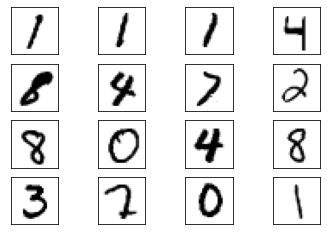

In [5]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

### Implementing the Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [7]:
discriminator = Discriminator().to(device=device)
# send discriminator model to the device object created earlier to use a GPU if it's one available

### Implementing the Generator
Since the generator is going to generate more complex data, it is necessary to increase the dimensions of the input from the latent space. In this case, the generator will be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image.

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)
# send generator model to the device object created earlier to use a GPU if it's one available

In __line 12__, we use the hyperbolic tangent function `Tanh()` as the activation of the output layer since the output coefficients should be in the interval from -1 to 1. In __line 20__, we instantiate the generator and send it to device to use the GPU if one is available.

### Training the Models

In [9]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [10]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5692477226257324
Epoch: 0 Loss G.: 0.47790801525115967
Epoch: 1 Loss D.: 0.14374998211860657
Epoch: 1 Loss G.: 5.175516128540039
Epoch: 2 Loss D.: 0.01926848478615284
Epoch: 2 Loss G.: 4.7195563316345215
Epoch: 3 Loss D.: 0.046195365488529205
Epoch: 3 Loss G.: 4.74737024307251
Epoch: 4 Loss D.: 0.11068927496671677
Epoch: 4 Loss G.: 5.1093831062316895
Epoch: 5 Loss D.: 0.019640032202005386
Epoch: 5 Loss G.: 3.969994068145752
Epoch: 6 Loss D.: 0.21670827269554138
Epoch: 6 Loss G.: 3.0092053413391113
Epoch: 7 Loss D.: 0.2642088532447815
Epoch: 7 Loss G.: 2.6280152797698975
Epoch: 8 Loss D.: 0.20325316488742828
Epoch: 8 Loss G.: 3.3397650718688965
Epoch: 9 Loss D.: 0.3616112768650055
Epoch: 9 Loss G.: 2.2936105728149414
Epoch: 10 Loss D.: 0.3907531201839447
Epoch: 10 Loss G.: 2.827519416809082
Epoch: 11 Loss D.: 0.33663520216941833
Epoch: 11 Loss G.: 2.374356746673584
Epoch: 12 Loss D.: 0.2610163390636444
Epoch: 12 Loss G.: 1.9030958414077759
Epoch: 13 Loss D.: 0.388774

Some of the tensors don’t need to be sent to the GPU explicitly with device. This is the case with `generated_samples` in __line 11__, which will already be sent to an available GPU since `latent_space_samples` and `generator` were sent to the GPU previously.

### Reviewing the GAN Generator

In [11]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

To plot `generated_samples`, move the data back to the CPU in case it’s running on the GPU by calling `.cpu()`. Call `.detach()` before using Matplotlib to plot the data.

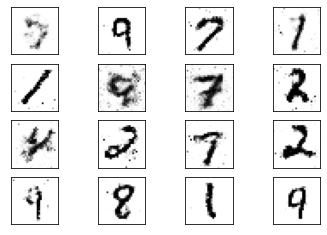

In [12]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])